# Latent Space Approaches to Social Network Analysis

In [202]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
from scipy.linalg import fractional_matrix_power

np.random.seed(42)

## Florentine Families Network

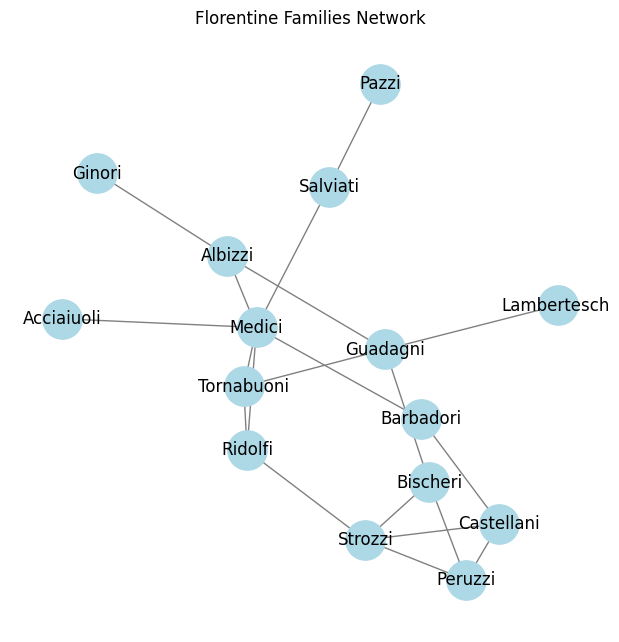

In [3]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()


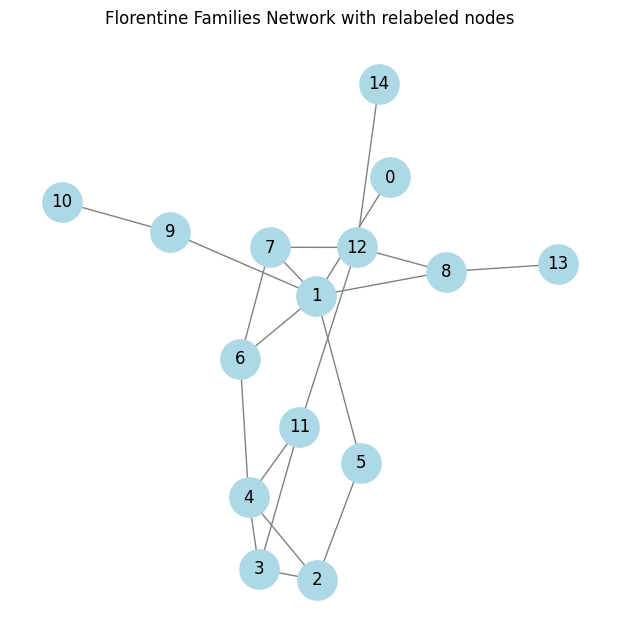

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


In [4]:
G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

In [5]:
nx.to_numpy_array(G, dtype=int)

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

<Axes: >

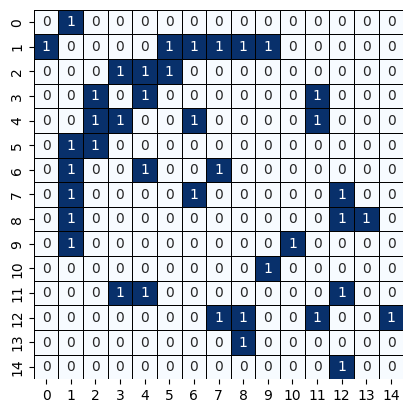

In [9]:
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=True, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='black')

## Latent Space

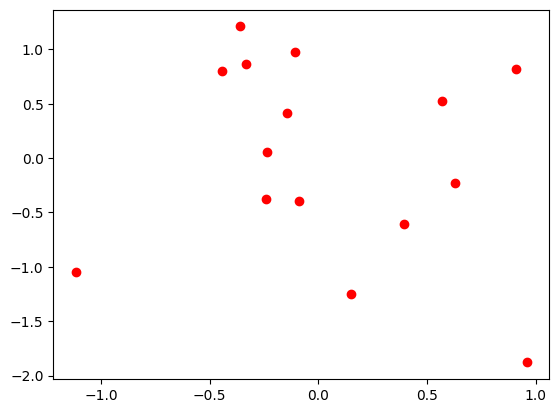

In [11]:
n = len(G.nodes)

Z = np.random.randn(n, 2)
plt.plot(Z[:,0],Z[:,1], 'ro')
plt.show()

## Likelihood

In [27]:
def loglikelihood(Z,a):
    total = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j in G.neighbors(i):
                eta = a * ( 1 - 0.05 * np.linalg.norm(Z[i] - Z[j])**2)
                total += eta * 1  + np.log(expit(-eta))
            elif j != i:
                eta = a * ( 1 - 0.05 * np.linalg.norm(Z[i] - Z[j])**2)
                total += np.log(expit(-eta))
    return total

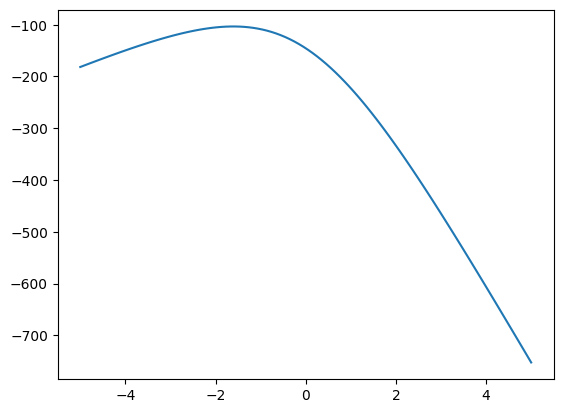

In [28]:
plt.plot(np.linspace(-5,5,100),[loglikelihood(Z,t) for t in np.linspace(-5,5,100)])
plt.show()

In [17]:
def grad_loglikelihood(Z,a):
    grad_Z = np.zeros_like(Z)
    grad_a = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                y = 1.0 if j in G.neighbors(i) else 0.0
                dist = 0.05 * np.linalg.norm(Z[i] - Z[j])**2
                eta = a* ( 1 - dist )
                grad_Z[i,:] += (-1) * a * (Z[i] - Z[j]) * (y - expit(eta))
                grad_a += (1-dist) * (y - expit(eta))  
    return grad_Z, grad_a

-151.47604030496007
-103.78143669980368


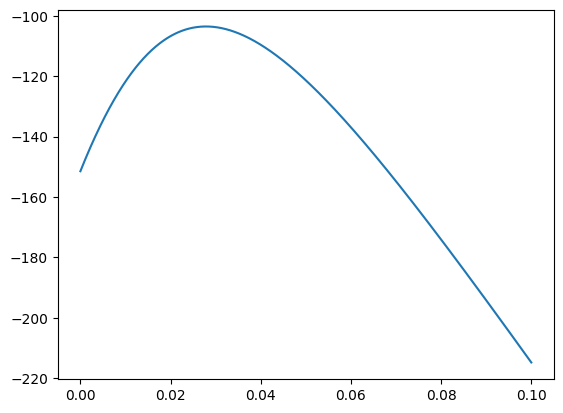

In [19]:
grad_Z,  grad_a = grad_loglikelihood(Z,0.1)
lr = 0.03
print(loglikelihood(Z,0.1))
print(loglikelihood(Z +lr*grad_Z,0.1+lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[loglikelihood(Z +lr*grad_Z,0.1+lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

### Searching MLE

In [168]:
def SearchingMLE(Z_init, a_init, tol=1e-1, max_iter=1000, alpha_init=0.1, rho=0.5, c=1e-4):
    Z0 = Z_init
    historyZ = [Z0]

    a0 = a_init
    historya = [a0]
    
    for i in range(max_iter):
        grad_Z,  grad_a = grad_loglikelihood(Z0,a0)
        if np.linalg.norm(grad_Z) + np.abs(grad_a) < tol:
            break  # Convergence criterion
        
        alpha = alpha_init
        
        # Line search using the Armijo condition
        while loglikelihood(Z0 + alpha * grad_Z,a0 + alpha*grad_a) < loglikelihood(Z0,a0)+ c * alpha * (np.trace(np.transpose(grad_Z) @ Z0) + grad_a * a0):
            alpha *= rho
        
        # Update step
        Z0 = Z0 + alpha * grad_Z  
        a0 = a0 + alpha * grad_a
        
        historyZ.append(Z0)
        historya.append(a0)
    
    return  Z0, a0, historyZ, historya

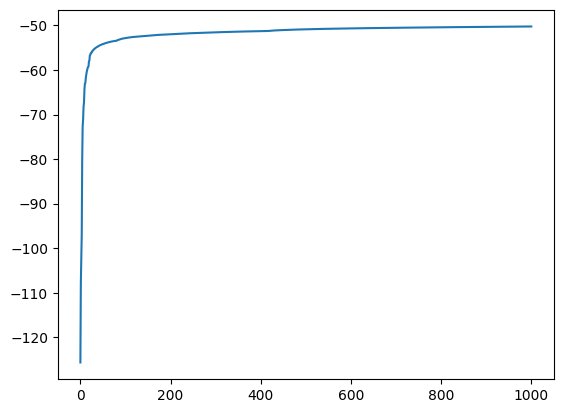

In [169]:
Z0, a0, historyZ, historya  = SearchingMLE(np.random.randn(n, 2),np.random.randn())
Z0 = Z0 - np.mean(Z0, axis=0)
plt.plot([loglikelihood(historyZ[t],historya[t]) for t in range(len(historya))])
plt.show()

In [170]:
print(loglikelihood(Z0,a0))
print(loglikelihood(np.random.randn(n, 2),np.random.randn()))

-50.22911888576101
-116.57978938368757


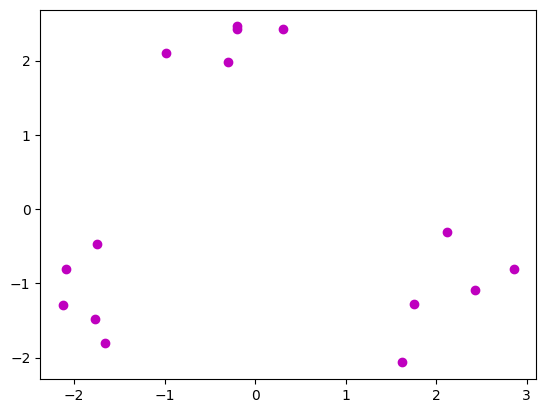

In [178]:
plt.plot(Z0[:,0],Z0[:,1], 'mo')
plt.show()

### Sociomatrix

In [318]:
Z0

array([[-1.75227757, -0.47084449],
       [ 2.85707489, -0.80193781],
       [ 0.30539907,  2.42721058],
       [-1.66000916, -1.80374708],
       [ 2.42936679, -1.0823978 ],
       [-1.76773596, -1.48450676],
       [-2.12618981, -1.28815066],
       [-0.20588896,  2.42052438],
       [-0.98700675,  2.09943707],
       [-2.09401976, -0.80461262],
       [ 2.11676298, -0.3068641 ],
       [-0.19562714,  2.45809805],
       [ 1.62602051, -2.06465447],
       [ 1.75189988, -1.27662183],
       [-0.297769  ,  1.97906754]])

In [319]:
a0

np.float64(-10.798965775949597)

In [321]:
Y = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            Y[i,j] = expit(a0 * (1 - 0.05 * np.linalg.norm(Z0[i] - Z0[j])**2))

<Axes: >

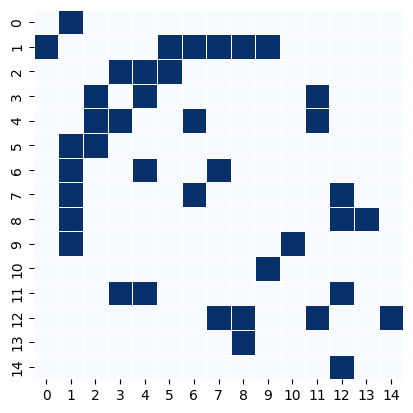

In [325]:
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')

<Axes: >

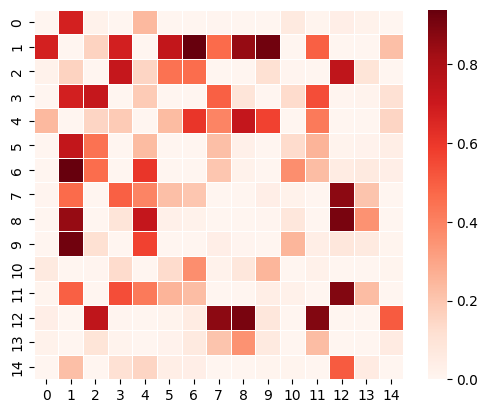

In [326]:
sns.heatmap(Y, annot=False, cmap="Reds", cbar=True, square=True, linewidths=0.5, linecolor='white')

## A priori distribution

In [174]:
def logpriori(Z,a,var=10):
    return (-1) * (np.log((2*np.pi*var)**((n+1)/2)) + 0.5 * np.sum(Z**2)/var + 0.5 * a**2 / var)

In [175]:
def grad_logpriori(Z,a,var=10):
    grad_Z = np.zeros_like(Z)
    for i in G.nodes():
        grad_Z[i,:] = (-1) * Z[i,:] / var
    grad_a = (-1) * a / var  
    return grad_Z, grad_a

-33.93932991440184
-33.12369727522713


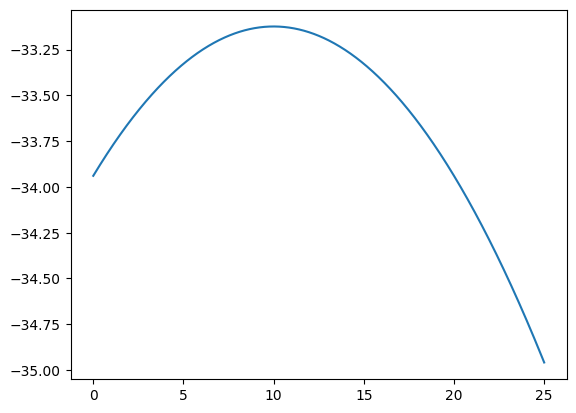

In [177]:
grad_Z,  grad_a = grad_logpriori(Z,0.1)
lr = 10
print(logpriori(Z,0.1))
print(logpriori(Z +lr*grad_Z,0.1+lr*grad_a))
plt.plot(np.linspace(0.0,25.0,1000),[logpriori(Z +lr*grad_Z,0.1+lr*grad_a) for lr in np.linspace(0.0,25.0,1000)])
plt.show()

## Potential energy

In [180]:
def U(Z,a,var=100):
    return (-1) * (loglikelihood(Z,a) + logpriori(Z,a,var))

def grad_U(Z,a,var=100):
    grad_Z_likelihood, grad_a_likelihood = grad_loglikelihood(Z,a)
    grad_Z_priori, grad_a_priori = grad_logpriori(Z,a,var)
    grad_Z = grad_Z_likelihood + grad_Z_priori
    grad_a = grad_a_likelihood + grad_a_priori
    return -grad_Z, -grad_a

203.10198158805704
155.11117871502063


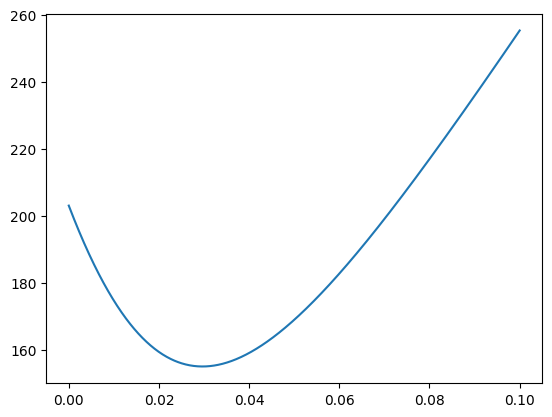

In [181]:
grad_Z,  grad_a = grad_U(Z,0.01)
lr = 0.03
print(U(Z,0.1))
print(U(Z - lr*grad_Z,0.1 - lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[U(Z -lr*grad_Z,0.1-lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

## Applying Hamiltonian Monte Carlo Algorithm

In [207]:
def compute_Z_star(Z, Z0):
    """ Computes Z* = Z0 Z^T (Z Z0^T Z0 Z^T)^(-1/2) Z using SVD """
    A = Z @ Z0.T @ Z0 @ Z.T  # Compute A = Z Z0^T Z0 Z^T
    
    # Compute A^(-1/2) using SVD
    U, S, _ = np.linalg.svd(A)
    S_inv_sqrt = np.diag(1.0 / np.sqrt(S))
    A_inv_sqrt = U @ S_inv_sqrt @ U.T
    
    # Compute Z*
    return Z0 @ Z.T @ A_inv_sqrt @ Z

In [208]:
compute_Z_star(np.random.randn(n,2), Z0)

array([[-1.09350771, -0.30892498],
       [ 1.78951094, -0.55055336],
       [ 0.18079033,  1.62896115],
       [-1.03025769, -1.20455463],
       [ 1.52329126, -0.73713821],
       [-1.09893862, -0.98968691],
       [-1.32385377, -0.85630732],
       [-0.13882447,  1.62660556],
       [-0.62581616,  1.4142093 ],
       [-1.30576134, -0.53167323],
       [ 1.32462148, -0.21494533],
       [-0.13256599,  1.65179907],
       [ 1.02516414, -1.39351621],
       [ 1.10056934, -0.8647596 ],
       [-0.19442166,  1.33048471]])

In [300]:
def hmc(Z_init, a_init, num_samples, epsilon=0.05, L=3, std_dev=1.0):
    samples_Z = [Z_init]
    samples_a = [a_init]
    Z = Z_init.copy()
    a = a_init.copy()
    
    for _ in range(num_samples):

        grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])


        ### HMC algorithm for Z
        p = np.random.normal(0, std_dev, size=Z.shape)
        current_p = p.copy()
        #Leapfrog integration
        p -= epsilon * grad_Z / 2        
        for _ in range(L):
            Z += epsilon * p
            grad_Z,  grad_a = grad_U(Z,samples_a[-1])
            p -= epsilon * grad_Z
        p -= epsilon * grad_Z / 2
        p = -p  # Negate momentum to make the proposal symmetric
        # Hamiltonian
        current_U = U(samples_Z[-1],samples_a[-1])
        current_K = np.sum(current_p ** 2) / 2
        current_H = current_U + current_K
        proposed_U = U(Z,samples_a[-1])
        proposed_K = np.sum(p ** 2) / 2
        proposed_H = proposed_U + proposed_K
        # Metropolis-Hastings acceptance rate
        if np.random.rand() > np.exp(current_H - proposed_H):
            Z_C = compute_Z_star(Z, Z_init)
            samples_Z.append(Z_C.copy())
        else:
            samples_Z.append(samples_Z[-1])

        grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])

        ### HMC algorithm for a
        p = np.random.normal(0, std_dev, size=1)
        current_p = p.copy()
        #Leapfrog integration
        p -= epsilon * grad_a / 2        
        for _ in range(L):
            a += epsilon * p
            grad_Z,  grad_a = grad_U(samples_Z[-1],a)
            p -= epsilon * grad_a
        p -= epsilon * grad_a / 2
        p = -p  # Negate momentum to make the proposal symmetric
        # Hamiltonian
        current_U = U(samples_Z[-1],samples_a[-1])
        current_K = np.sum(current_p ** 2) / 2
        current_H = current_U + current_K
        proposed_U = U(samples_Z[-1],a)
        proposed_K = np.sum(p ** 2) / 2
        proposed_H = proposed_U + proposed_K
        # Metropolis-Hastings acceptance rate
        if np.random.rand() > np.exp(current_H - proposed_H):
            samples_a.append(a.copy())
        else:
            samples_a.append(samples_a[-1])

    
    return samples_Z, samples_a

## Results and visualization

In [313]:
samples_Z, samples_a = hmc(Z0,a0,5000)

C:\Users\carlo\AppData\Local\Temp\ipykernel_17020\549072186.py:58: RuntimeWarning: overflow encountered in exp
  if np.random.rand() > np.exp(current_H - proposed_H):


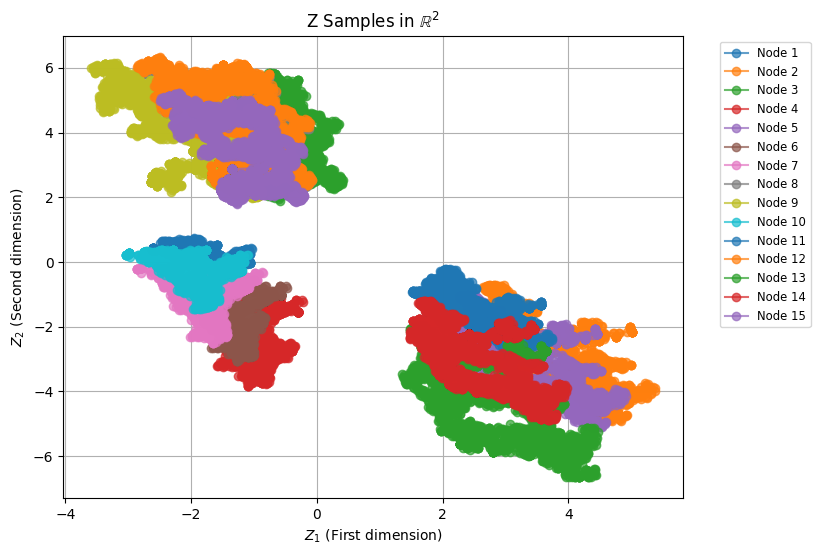

In [314]:
def plot_Z_samples(samples_Z):
    """
    Plots the trajectory of each row of Z in R^2, 
    differentiating them by color.
    
    Args:
        samples_Z (list of np.array): List of Z matrices of shape (15, 2).
    """
    samples_Z = np.array(samples_Z)  # Convert to numpy array
    num_points = samples_Z.shape[1]  # Number of rows in Z

    plt.figure(figsize=(8, 6))

    # Plot the trajectory of each row in Z
    for i in range(num_points):
        trace = samples_Z[:, i, :]  # Extract trajectory for point i
        plt.plot(trace[:, 0], trace[:, 1], marker="o", linestyle="-", alpha=0.7, label=f"Node {i+1}")

    plt.xlabel("$Z_1$ (First dimension)")
    plt.ylabel("$Z_2$ (Second dimension)")
    plt.title("Z Samples in $\\mathbb{R}^2$")
    plt.legend(loc="best", fontsize="small", bbox_to_anchor=(1.05, 1))
    plt.grid(True)
    plt.show()

# Llamada a la función con tus datos
plot_Z_samples(samples_Z)


In [315]:
samples_a

[np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 np.float64(-10.798965775949597),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]),
 array([-11.8626107]

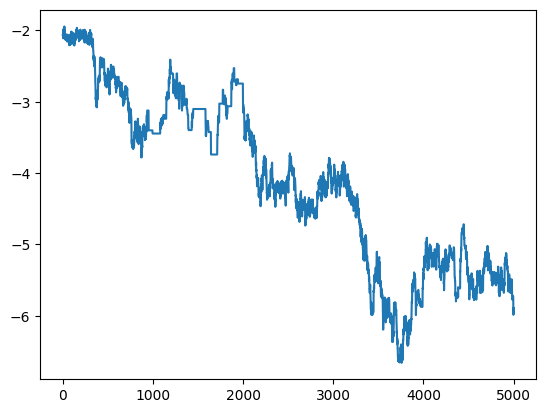

In [316]:
plt.plot(np.array(samples_Z)[:,12,:][:,1]) 

In [317]:
[-loglikelihood(samples_Z[i],samples_a[i]) for i in range(1,500)]

[np.float64(50.22911888576101),
 np.float64(50.22911888576101),
 np.float64(50.287170320636626),
 np.float64(50.33597160092264),
 np.float64(50.77795816551863),
 np.float64(51.95387201269953),
 np.float64(50.980937148240514),
 np.float64(52.718109233905544),
 np.float64(50.80020696669454),
 np.float64(51.212260875431035),
 np.float64(51.8016885617846),
 np.float64(52.18211163246447),
 np.float64(50.24468255286564),
 np.float64(53.742271132888675),
 np.float64(51.413143347761924),
 np.float64(52.253586268772274),
 np.float64(52.081279626422585),
 array([55.96938791]),
 array([53.50159356]),
 array([52.21996171]),
 array([51.94020558]),
 array([53.87842966]),
 array([51.17548636]),
 array([51.88126899]),
 array([50.20869542]),
 array([50.06194996]),
 array([50.36644556]),
 array([50.08970163]),
 array([51.61904388]),
 array([50.79541208]),
 array([51.28046954]),
 array([51.86334556]),
 array([52.08258998]),
 array([50.7060291]),
 array([54.83425006]),
 array([52.35980302]),
 array([51.34

## References

[1] 